In [20]:
import subprocess

# Lấy danh sách các thư viện đã cài đặt
result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)
installed_libraries = result.stdout

# Lọc các thư viện cần thiết
libraries_needed = []
keywords = ['torch', 'torchvision', 'glob', 'os', 'numpy', 'PIL', 'scikit-learn', 'seaborn']
for line in installed_libraries.splitlines():
    for keyword in keywords:
        if keyword in line.lower():
            libraries_needed.append(line.strip())

# In danh sách các thư viện cần thiết
for lib in libraries_needed:
    print(lib)


jupyterlab-widgets @ file:///C:/b/abs_62picw9xos/croot/jupyterlab_widgets_1709323131962/work
numpy @ file:///C:/b/abs_c1ywpu18ar/croot/numpy_and_numpy_base_1708638681471/work/dist/numpy-1.26.4-cp312-cp312-win_amd64.whl#sha256=becc06674317799ad0165a939a7613809d0bee9bd328a1e4308c57c39cacf08c
packaging @ file:///C:/b/abs_cc1h2xfosn/croot/packaging_1710807447479/work
scikit-learn==1.4.2
seaborn==0.13.2
torch==2.2.2
torchaudio==2.2.2
torchvision==0.17.2
torchvision==0.17.2


In [21]:
with open('requirements.txt', 'w') as f:
    for lib in libraries_needed:
        f.write(lib.split()[0] + '\n')


In [1]:
import torch
import os
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc

In [2]:
def imshow(img, text=None, save=False):
  npimg = img.cpu().numpy()
  plt.axis('off')

  if text:
    plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [3]:
class DatasetSign(Dataset):
    def __init__(self,root: str, name_dataset: str, transform=None):
        self.root = root
        self.transform = transform
        
        self.dir = self.root + 2*name_dataset
        self.data = []
        self.labels = []
        self._load_data()
        
    def _load_data(self):
        self.folder = glob(self.dir + "/*/")
        for index in self.folder:
            index_path = os.path.join(index)
            if os.path.isdir(index_path):
                for img_name in os.listdir(index_path):
                    img_path = os.path.join(index_path, img_name)
                    if 'original' in img_name or 'G' in img_name:
                        self.data.append(img_path)
                        self.labels.append(1)  # 1 cho chữ ký thật
                    elif 'forgeries' in img_name or 'F' in img_name:
                        self.data.append(img_path)
                        self.labels.append(0)  # 0 cho chữ ký giả
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Chuyển sang grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# datasign = DatasetSign(root='/kaggle/input/handwritten-signature-datasets', name_dataset='/CEDAR')
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Thay đổi kích thước ảnh
    transforms.ToTensor(),  # Chuyển ảnh thành tensor
    transforms.Normalize((0.5,), (0.5,))  # Chuẩn hóa ảnh
])

dataset1 = DatasetSign(root='dataset/archive (1)', name_dataset='/CEDAR', transform=transform)
dataset2 = DatasetSign(root='dataset/archive (1)', name_dataset='/BHSig260-Hindi', transform=transform)
dataset3 = DatasetSign(root='dataset/archive (1)', name_dataset='/BHSig260-Bengali', transform=transform)
len(dataset1),len(dataset2),len(dataset3)

(2640, 8640, 5400)

In [5]:
# len(train_loader), len(test_loader)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Khởi tạo mô hình



In [7]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
print(device)

cuda


In [8]:
# Trực quan hóa các thông số metric với seaborn
def visualize_metrics_seaborn(metrics):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Evaluation Metrics')
    plt.ylim([0, 1])
    
    # Hiển thị giá trị trên các cột
    for i, value in enumerate(metrics_values):
        plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    plt.show()

In [9]:


def evaluate_model(discriminator, test_loader, device):
    all_labels = []
    all_predictions = []
    discriminator.eval()  # Đặt mô hình ở chế độ đánh giá
    with torch.no_grad():  # Tắt tính toán gradient cho quá trình đánh giá
        for real_images, labels in test_loader:
            real_images = real_images.to(device)
            labels = labels.to(device).float()
            
            outputs = discriminator(real_images).view(-1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
    
    # Tính toán ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    
    # Tìm ngưỡng giá trị tối ưu
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Vẽ ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal threshold = %0.2f' % optimal_threshold)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    all_predictions = [1 if x > optimal_threshold else 0 for x in all_predictions]

    classification_report_result = classification_report(all_labels, all_predictions)
    print(classification_report_result)
    
    # Tính toán và lưu lại classification report dưới dạng từ điển
    classification_report_dict = classification_report(all_labels, all_predictions, output_dict=True)
    # print(classification_report_dict)
    
    # Nếu bạn chỉ muốn lưu các thông số chính như precision, recall, f1-score, accuracy
    metrics = {
        "accuracy": classification_report_dict["accuracy"],
        "precision": classification_report_dict["0.0"]["precision"],
        "recall": classification_report_dict["0.0"]["recall"],
        "f1-score": classification_report_dict["0.0"]["f1-score"]
    }
    
    # print(metrics)
    visualize_metrics_seaborn(metrics)

    # Đặt mô hình trở lại chế độ huấn luyện
    discriminator.train()

    return all_labels, all_predictions, optimal_threshold, metrics

# Đánh giá mô hình sau khi huấn luyện
# all_labels, all_predictions, optimal_threshold, classification_report_dict, metrics = evaluate_model(discriminator, test_loader, device)


In [10]:
def train_dcgan(generator, discriminator, train_loader, beta1, epochs, lr, device,criterion, optimizerD, optimizerG):

    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(train_loader):
            batch_size = real_images.size(0)
    
            fake_labels = torch.zeros(batch_size).to(device)
            real_labels = torch.ones(batch_size).to(device)
    
            # Huấn luyện Discriminator
            discriminator.zero_grad()
            
            # Chuyển real images và labels lên device
            real_images = real_images.to(device)
            labels = labels.to(device).float()
            
            # Phân biệt ảnh thật với nhãn thật
            outputs = discriminator(real_images).view(-1)
            d_loss_real = criterion(outputs, labels)
            d_loss_real.backward()
            optimizerD.step()
    
            # Sinh ra ảnh giả
            # generator.zero_grad()
            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            
            # Phân biệt ảnh giả với nhãn giả (0)
            outputs = discriminator(fake_images.detach()).view(-1)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
    
            # Tổng hợp loss và cập nhật weights của Discriminator
            d_loss = d_loss_real + d_loss_fake
            optimizerD.step()
    
            generator.zero_grad()
            # label.fill_(real_labels)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake_images.detach()).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, real_labels)
            # Calculate gradients for G
            errG.backward()
            # D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
    
            
    
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                      Loss D: {d_loss.item()}")

    return generator, discriminator



    

Training on CEDAR
Epoch [0/10] Batch 0/33                       Loss D: 1.1457388401031494
Epoch [0/10] Batch 1/33                       Loss D: 0.289132297039032
Epoch [0/10] Batch 2/33                       Loss D: 0.15432335436344147
Epoch [0/10] Batch 3/33                       Loss D: 0.028240950778126717
Epoch [0/10] Batch 4/33                       Loss D: 0.00828828290104866
Epoch [0/10] Batch 5/33                       Loss D: 0.014070965349674225
Epoch [0/10] Batch 6/33                       Loss D: 0.005685294046998024
Epoch [0/10] Batch 7/33                       Loss D: 0.012290513142943382
Epoch [0/10] Batch 8/33                       Loss D: 0.008200814947485924
Epoch [0/10] Batch 9/33                       Loss D: 0.011039678007364273
Epoch [0/10] Batch 10/33                       Loss D: 0.009771678596735
Epoch [0/10] Batch 11/33                       Loss D: 0.00303496140986681
Epoch [0/10] Batch 12/33                       Loss D: 0.003737915772944689
Epoch [0/10] Ba

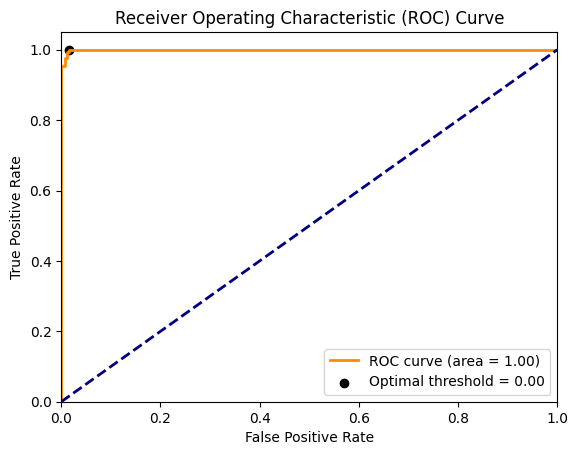

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       273
         1.0       0.98      1.00      0.99       255

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528



C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


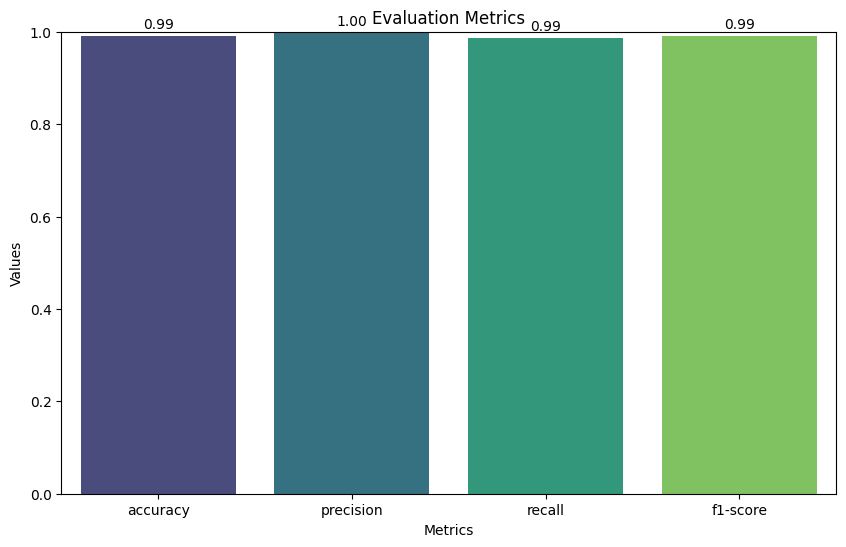

Training on BHSig260-Hindi
Epoch [0/10] Batch 0/108                       Loss D: 1.0988044738769531
Epoch [0/10] Batch 1/108                       Loss D: 3.981424570083618
Epoch [0/10] Batch 2/108                       Loss D: 0.7158927917480469
Epoch [0/10] Batch 3/108                       Loss D: 0.7107167840003967
Epoch [0/10] Batch 4/108                       Loss D: 1.2149572372436523
Epoch [0/10] Batch 5/108                       Loss D: 0.5495349764823914
Epoch [0/10] Batch 6/108                       Loss D: 0.60955411195755
Epoch [0/10] Batch 7/108                       Loss D: 0.7262547612190247
Epoch [0/10] Batch 8/108                       Loss D: 0.8919190764427185
Epoch [0/10] Batch 9/108                       Loss D: 1.476499080657959
Epoch [0/10] Batch 10/108                       Loss D: 1.5940300226211548
Epoch [0/10] Batch 11/108                       Loss D: 1.03386390209198
Epoch [0/10] Batch 12/108                       Loss D: 0.635819673538208
Epoch [0/10] Ba

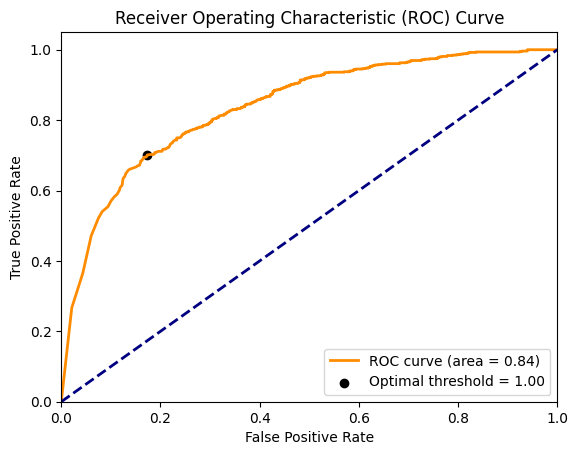

              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       945
         1.0       0.77      0.70      0.73       783

    accuracy                           0.77      1728
   macro avg       0.77      0.76      0.76      1728
weighted avg       0.77      0.77      0.77      1728



C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


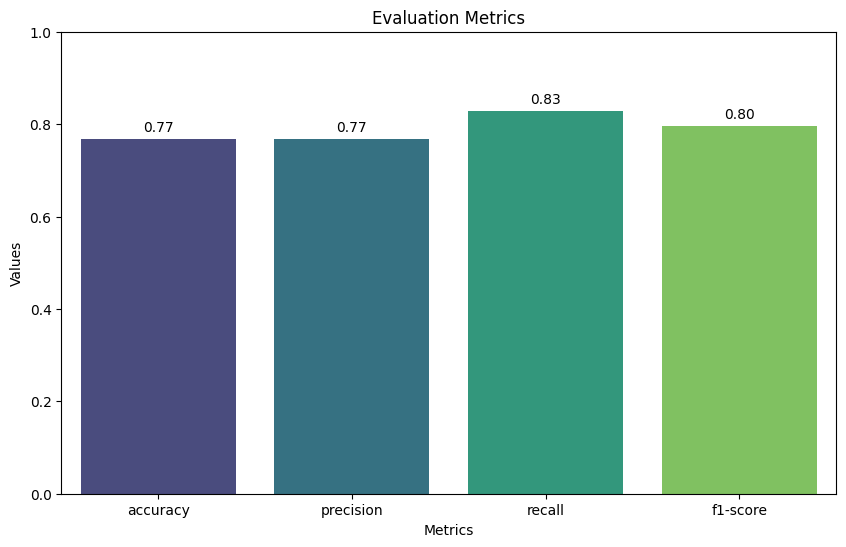

Training on BHSig260-Bengali
Epoch [0/10] Batch 0/68                       Loss D: 1.2056901454925537
Epoch [0/10] Batch 1/68                       Loss D: 2.6884605884552
Epoch [0/10] Batch 2/68                       Loss D: 2.1255764961242676
Epoch [0/10] Batch 3/68                       Loss D: 1.0541213750839233
Epoch [0/10] Batch 4/68                       Loss D: 0.620360255241394
Epoch [0/10] Batch 5/68                       Loss D: 0.8334068059921265
Epoch [0/10] Batch 6/68                       Loss D: 1.211348295211792
Epoch [0/10] Batch 7/68                       Loss D: 0.539180338382721
Epoch [0/10] Batch 8/68                       Loss D: 0.6938928365707397
Epoch [0/10] Batch 9/68                       Loss D: 0.7156285643577576
Epoch [0/10] Batch 10/68                       Loss D: 0.7364601492881775
Epoch [0/10] Batch 11/68                       Loss D: 0.5829618573188782
Epoch [0/10] Batch 12/68                       Loss D: 0.5929738879203796
Epoch [0/10] Batch 13/68 

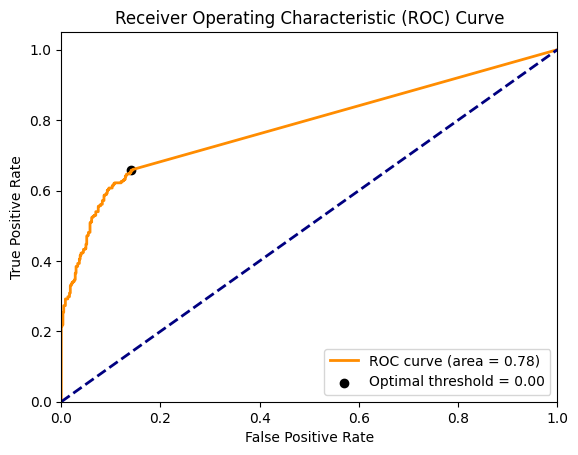

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       604
         1.0       0.79      0.66      0.71       476

    accuracy                           0.77      1080
   macro avg       0.77      0.76      0.76      1080
weighted avg       0.77      0.77      0.77      1080



C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


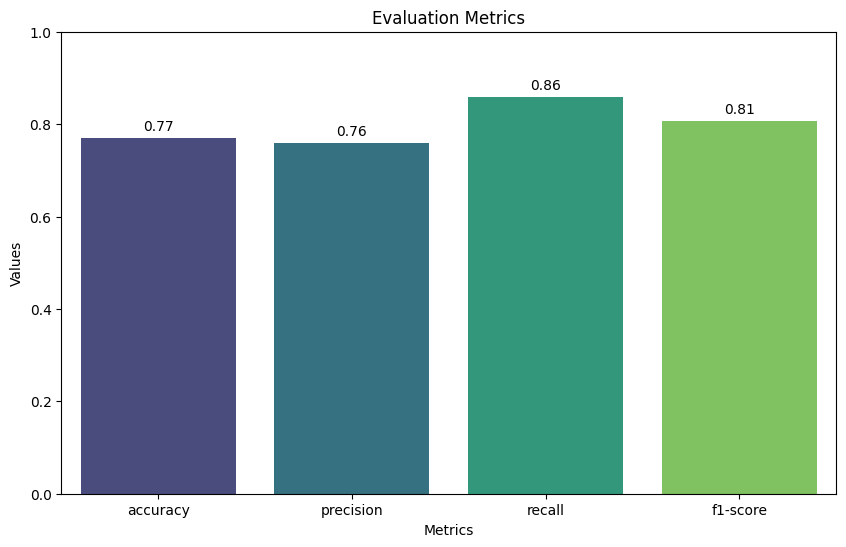

Results for CEDAR:
{'accuracy': 0.990530303030303, 'precision': 0.9962962962962963, 'recall': 0.9853479853479854, 'f1-score': 0.990791896869245}
Results for BHSig260-Hindi:
{'accuracy': 0.7685185185185185, 'precision': 0.7674190382728164, 'recall': 0.8275132275132275, 'f1-score': 0.7963340122199593}
Results for BHSig260-Bengali:
{'accuracy': 0.7694444444444445, 'precision': 0.7598828696925329, 'recall': 0.859271523178808, 'f1-score': 0.8065268065268065}


In [11]:
datasets = [('CEDAR', dataset1), ('BHSig260-Hindi', dataset2), ('BHSig260-Bengali', dataset3)]
# Khởi tạo các danh sách để lưu kết quả
generators = []
discriminators = []
metrics = []
classification_reports = []

for dataset_name, dataset in datasets:
    print(f'Training on {dataset_name}')
    
    # Khởi tạo lại mô hình cho từng bộ dữ liệu
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Định nghĩa loss function và optimizer
    criterion = nn.BCELoss()
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Chia bộ dữ liệu thành train và test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Huấn luyện mô hình
    generator, discriminator = train_dcgan(generator, discriminator, train_loader, beta1, num_epochs, lr, device, criterion, optimizerD, optimizerG)
    
    # Đánh giá mô hình
    labels, predictions, optimal_threshold, metric = evaluate_model(discriminator, test_loader, device)
    
    # Lưu kết quả
    generators.append(generator)
    discriminators.append(discriminator)
    metrics.append((dataset_name, metric))
    classification_reports.append((dataset_name, labels, predictions, optimal_threshold))

# In ra kết quả
for dataset_name, metric in metrics:
    print(f'Results for {dataset_name}:')
    print(metric)

Results for CEDAR:


C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


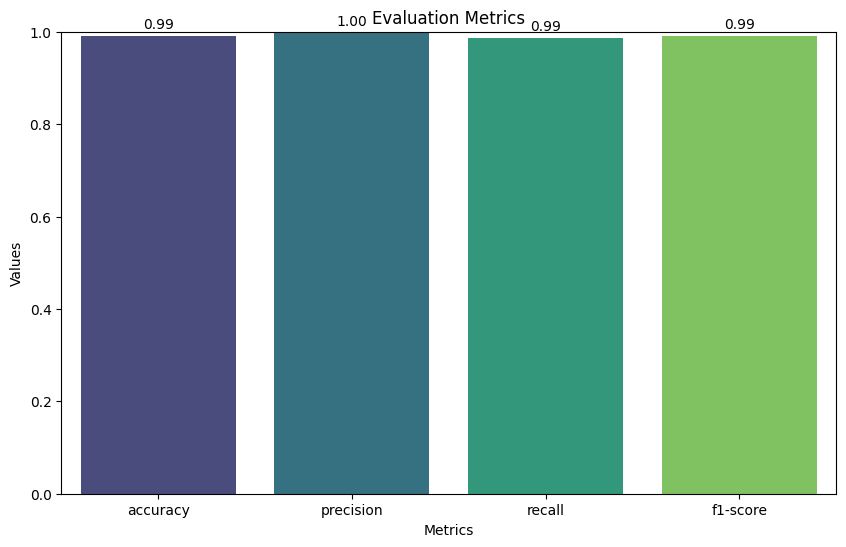

None
Results for BHSig260-Hindi:


C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


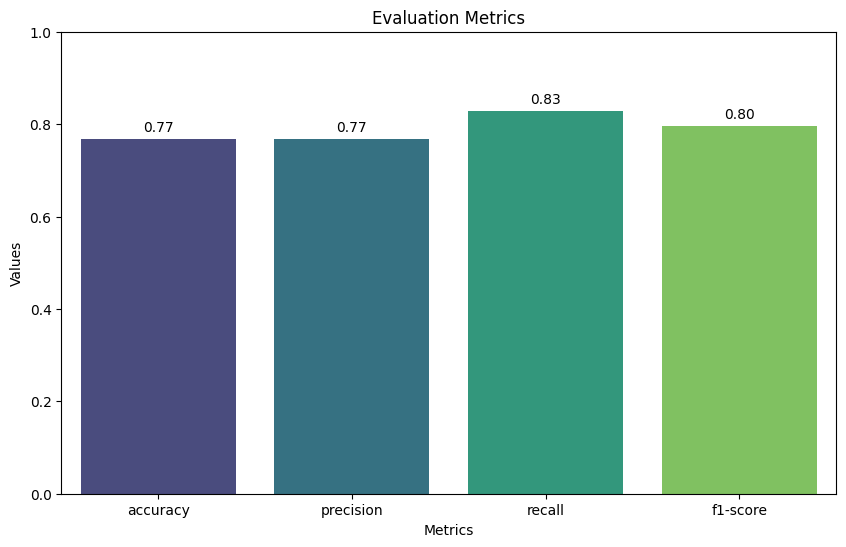

None
Results for BHSig260-Bengali:


C:\Users\TanLoc\AppData\Local\Temp\ipykernel_17860\337143034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


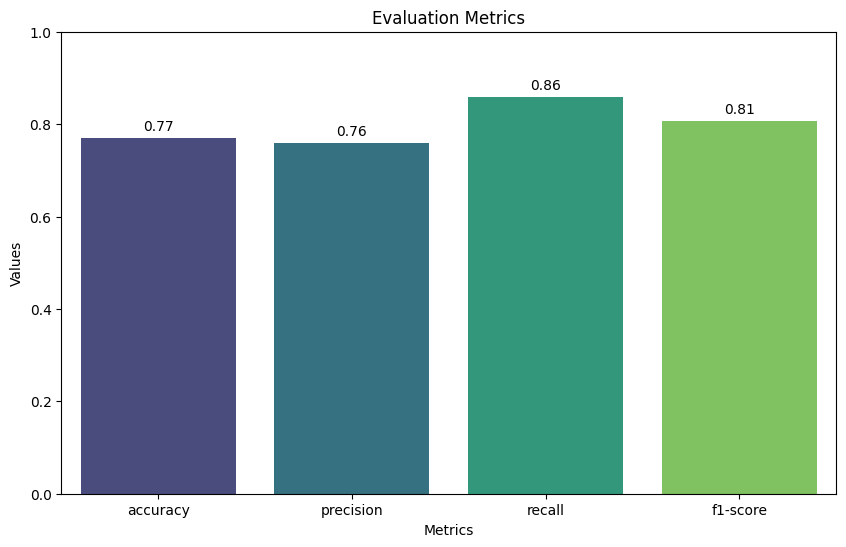

None


In [12]:
for dataset_name, metric in metrics:
    print(f'Results for {dataset_name}:')
    print(visualize_metrics_seaborn(metric))

In [14]:
!pip list


Package                   Version
------------------------- ------------
alembic                   1.13.1
anyio                     3.7.1
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
asttokens                 2.0.5
async-generator           1.10
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.11.0
beautifulsoup4            4.12.2
bleach                    4.1.0
blinker                   1.7.0
Brotli                    1.0.9
certifi                   2024.2.2
certipy                   0.1.3
cffi                      1.16.0
charset-normalizer        2.0.4
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.1
cryptography              42.0.5
cycler                    0.12.1
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
executing                 0.8.3
fastjsonschema            2.16.2
filelock                  3.13.1
fonttools         